## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)
- [References](#References)

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
##discovering the few first rows of our data set
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
sum(df.converted)/df.user_id.nunique()

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query("(group=='treatment' and landing_page!= 'new_page') or (group!='treatment' and landing_page== 'new_page') ").shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
null_data = df[df.isnull().any(axis=1)]
null_data.shape[0]

0

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2=df.query("(group=='treatment' and landing_page== 'new_page') or (group=='control' and landing_page=='old_page') ")
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
##the size of the new df 
df2.shape

(290585, 5)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
##getting the most occuring id
df2.user_id.value_counts(sort='descending').index[0]

773192

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2=df2.drop_duplicates(subset=['user_id'])

In [15]:
##check if te duplicated row is dropped
sum(df2.user_id.duplicated())

0

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
sum(df2.converted)/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
control_group=df2[df2['group']=='control']
sum(control_group.converted)/control_group.shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
treatment_group=df2[df2['group']=='treatment']
sum(treatment_group.converted)/treatment_group.shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
treatment_group.shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Your answer goes here.**

- I actually don't think there's sufficient evidence to that the new treatment page leads to more conversions. the results in c and b seems to be really close and don't really distinguishe between the convertion in the old page and the new page and maybe that is because we just focused on the 'converted' parameter

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Hypothesis**
                     $$H{0}(null-hypothesis): p_{old} >= p_{new}$$
                     $$H{1}(alter-hypothesis): p_{old} < p_{new}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
p_new=sum(df2.converted)/df2.shape[0] ##also can be obtained be df2.converted.mean() as the values are 1 ,0 

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old=sum(df2.converted)/df2.shape[0] ##same as p_new

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
n_new=treatment_group.shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old=control_group.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted =np.random.choice(treatment_group.converted,size=n_new,replace=True)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted =np.random.choice(control_group.converted,size=n_old,replace=True)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
new_page_converted.mean()-old_page_converted.mean()

-9.865557508192957e-05

- Very close to 0

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
p_diffs=[]
for i in range(0,10000):
    new_page_converted =np.random.choice(treatment_group.converted,size=n_new,replace=True)
    old_page_converted =np.random.choice(control_group.converted,size=n_old,replace=True)
    p_new=new_page_converted.mean()
    p_old=old_page_converted.mean()
    p_diffs.append(p_new-p_old)

In [28]:
obs_diff=treatment_group.converted.mean()-control_group.converted.mean() ##actual difference observed in ab_data.csv

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

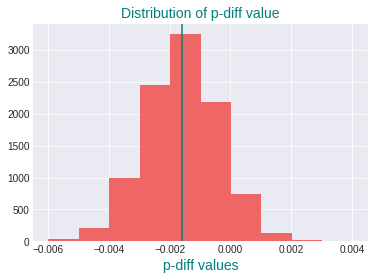

In [29]:
##changing style of the plot
plt.style.use('seaborn-darkgrid')
##plot The histogram
plt.hist(p_diffs, color='#EE6666');
plt.axvline(x=obs_diff,color='#008080');##ploting the line of the observed difference
plt.title("Distribution of p-diff value",fontsize=14,color='#008080');
plt.xlabel('p-diff values', fontsize = 14,color='#008080');

- As expected, the distribution of the difference in mean values is normal

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
(p_diffs>obs_diff).mean()##Calculating the p-value

0.50190000000000001

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer**
 - value calculated here is the p-value. the p-value determines whether we managed to reject the null hypothesis or not, if the p-value is less than or equal type 1 error, the we reject the null hypothesis. in this case p-value(0.505) is greater that type 1 error which is 0.05 and that proves that we failed to reject the null hypothesis

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = df2.query("landing_page=='old_page'")
convert_new = df2.query("landing_page=='new_page'")
n_old = convert_old.shape[0]
n_new = convert_new.shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [32]:
z_score, pval = sm.stats.proportions_ztest(count=[convert_new.converted.sum(),convert_old.converted.sum()], nobs=[n_new,n_old], value=0,alternative='larger')

In [33]:
z_score, pval

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer**
- Since the z-score is negative then the value lies "below" the mean and that fails to reject the null hypothesis, also, the p-value came to prove our stats as it's larger than alpha which is 0.05 so that is a significant proof that the diffs is more likely to equal the null hypothesis and that we can't reject the null hypothesis.
- Althought our results in **m.** part isn't equal to results in both **j.** and **k.** parts, they prove the same thing that is we cannot reject the null hypothesis as p-value in both of them is greater than alpha
- So, we can say that the new_page made no difference or isn't better than the old_page

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer**
- Since each row is either a conversion or no conversion that is categorical data with two distinct variables i.e, either ***1*** or ***0***, **Logistics Regression** is more suitable for this case

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
##diplaying the data set to look at its features 
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [35]:
### Creating tha dummy variables 
df2[['non_ab_page','ab_page']]=pd.get_dummies(df2['group'])
##diplaying the data set to look again at its features 
df2.head()

,user_id,timestamp,group,landing_page,converted,non_ab_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [36]:
##drop the other dummy vaiable 'non_ab_page ' as we will only use the 'ab_page' column
df2.drop(columns='non_ab_page',axis=1,inplace=True)
##diplaying the data set to look again at its features 
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


In [37]:
##Adding an intercept column
df2['intercept']=1

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [38]:
Log_model=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results=Log_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
##This cell is for solving the error occured when results.summury is called :"module 'scipy.stats' has no attribute 'chisqprob'"

from scipy import stats
stats.chisqprob = lambda chisq, df2: stats.chi2.sf(chisq, df2)
stats.junk = lambda chisq, df2: stats.chi2.sf(chisq, df2)

In [40]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 Oct 2020   Pseudo R-squ.:               8.077e-06
Time:                        19:55:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 
- The**$P_{value}$**= **0.19** , whis is less that 0.05 sothat fails to reject the null hypothesis too 
- The**$P_{value}$**does differ from the values in **Part II** for some reason, first, is **Part II** we generated the sample **randomly** for 10000 iterarions but here we used the actual data set. I think the second reason here is that we are dealing logistically 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- By adding more other factors to my regression model, this may increase the R-squared value and thus the variables will be more related to the output or the predicted feature.
- Although adding more additional terms may improve my model, there might be **Multicollinearity** and that happens when **two or more** of our factors are highly related to each other and that will cause alot of problems to our final result

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [41]:
countries=pd.read_csv('countries.csv')

In [42]:
df_new=df2.join(countries.set_index('user_id'),on="user_id")

In [43]:
df_new.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [44]:
df_new[['CA', 'UK', 'US']]=pd.get_dummies(df_new['country'])
df_new.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,1


In [45]:
Log_model=sm.Logit(df_new['converted'],df_new[['intercept','UK', 'US']])
results=Log_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 12 Oct 2020   Pseudo R-squ.:               1.521e-05
Time:                        19:55:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [46]:
Log_model=sm.Logit(df_new['converted'],df_new[['intercept','ab_page','UK', 'US']])
results=Log_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 12 Oct 2020   Pseudo R-squ.:               2.323e-05
Time:                        19:55:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

- the UK conversion rate is different from CA conversion rate by : exp(0.0506) 
- the US conversion rate is different from CA conversion rate by : exp(0.0408) 
- From the results shown above, it seems that the country factor doesn't have effect on conversion of an individual as the **p-values** for both UK and US is grater than 0.05

<a id='conclusions'></a>
## Conclusions

In this project, we've applied alot of practical statistics and Regression methods and concepts to understand the results of an A/B test run by an e-commerce website and understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision. From the most of results we can say that they'd better keep the old page.


<a id='References'></a>
## References
<ul><li><a href=https://github.com/statsmodels/statsmodels/issues/3931>https://github.com/statsmodels/statsmodels/issues/3931</a></li>
<li><a href=https://problemsolvingwithpython.com/06-Plotting-with-Matplotlib/06.13-Plot-Styles/ >https://problemsolvingwithpython.com/06-Plotting-with-Matplotlib/06.13-Plot-Styles/</a> 
</li>
<li><a href=https://www.investopedia.com/terms/z/z-test.asp/ >https://www.investopedia.com/terms/z/z-test.asp </a></li>
<li><a href=https://www.khanacademy.org/math/ap-statistics/density-curves-normal-distribution-ap/measuring-position/v/z-score-introduction > https://www.khanacademy.org/math/ap-statistics/density-curves-normal-distribution-ap/measuring-position/v/z-score-introduction </a> </li> </ul>


In [49]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0